In [2]:
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nb

In [3]:
sns.set_context('poster')

In [4]:
allen = nb.load('/home/julia/data/gradients/atlas/allen_api/template.nii.gz')

In [5]:
jo = nb.load('/home/julia/data/gradients/atlas/ABI_template_25um.nii')

### Transform cells to Allen brain volume space

In [4]:
def cells2allen(x, y, z, origin=[264, 160, 228], factor=25):
    return x/factor+origin[0], -y/factor+origin[1], z/factor+origin[2]

In [5]:
x, y, z = cells2allen(np.load('/home/julia/data/gradients/atlas/epfl_cell_atlas/x.npy'),
                      np.load('/home/julia/data/gradients/atlas/epfl_cell_atlas/y.npy'),
                      np.load('/home/julia/data/gradients/atlas/epfl_cell_atlas/z.npy'))

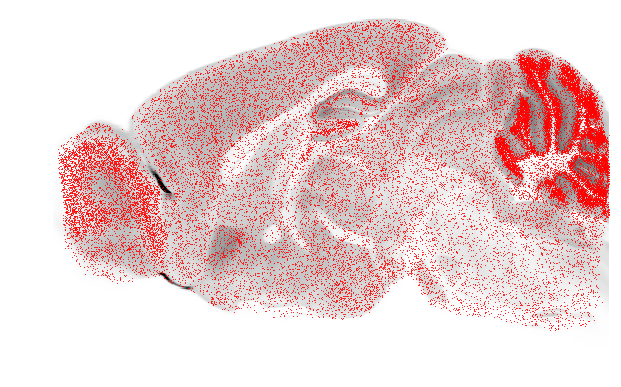

In [25]:
z_slice = 250
z_idx = np.where(np.abs(z-z_slice)<.05)
fig = plt.figure(figsize=(10,10))
plt.imshow((allen.get_data()[:,:,z_slice].T),  cmap='Greys', aspect='equal');
plt.scatter(x[z_idx], y[z_idx], marker='.', color='red', s=1);
plt.axis('off');

In [14]:
np.save('/home/julia/data/gradients/atlas/epfl_cell_atlas/x2vol.npy', x)
np.save('/home/julia/data/gradients/atlas/epfl_cell_atlas/y2vol.npy', y)
np.save('/home/julia/data/gradients/atlas/epfl_cell_atlas/z2vol.npy', z)

### Transform cells to our template space

In [7]:
def allen2jo(x,y,z):
    return z, -x+528, -y+320

In [8]:
x, y, z = allen2jo(x,y,z)

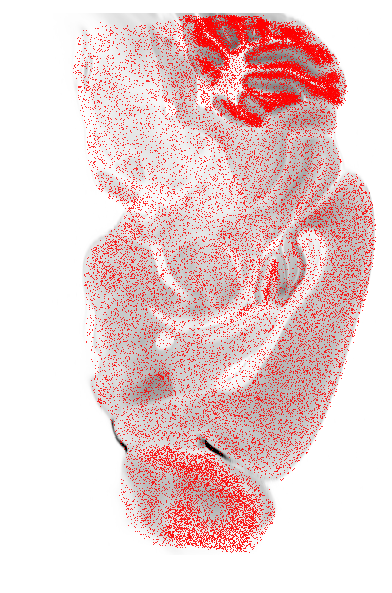

In [41]:
x_slice = 250
x_idx = np.where(np.abs(x-x_slice)<0.05)
sns.set_context('poster')
fig = plt.figure(figsize=(10,10))
plt.imshow(jo.get_data()[x_slice,:,:],  cmap='Greys', aspect='equal');
plt.scatter(z[x_idx], y[x_idx], marker='.', color='red', s=1);
plt.axis('off');

In [42]:
np.save('/home/julia/data/gradients/atlas/epfl_cell_atlas/x2jo.npy', x)
np.save('/home/julia/data/gradients/atlas/epfl_cell_atlas/y2jo.npy', y)
np.save('/home/julia/data/gradients/atlas/epfl_cell_atlas/z2jo.npy', z)

### Transform volumes from Allen to our template space

In [49]:
def allen2jo_vol(data):
    data = np.swapaxes(np.swapaxes(data, 0,1), 0,2)
    data = np.flip(np.flip(data,1),2)
    return data

In [77]:
layers = ['1', '2_3', '4', '5', '6a', '6b']
layer_img = np.zeros(jo.get_data().shape)
i = 1
for l in layers:
    data_allen = nb.load('/home/julia/data/gradients/atlas/allen_api/l%s.nii.gz' %l).get_data()
    data_jo = allen2jo_vol(data_allen)
    nb.save(nb.Nifti1Image(data_jo, jo.affine, jo.header), 
            '/home/julia/data/gradients/atlas/allen_api/l%s_2jo.nii.gz' %l)
    layer_img[np.where(data_jo==1)]=i
    i+=1
layer_img[layer_img==0] = np.nan

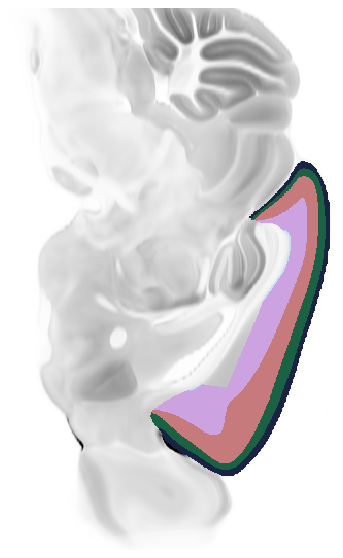

In [86]:
fig = plt.figure(figsize=(10,10))
plt.imshow(jo.get_data()[200,:,:],  cmap='Greys', aspect='equal');
plt.imshow(layer_img[200,:,:],  cmap="cubehelix", aspect='equal', vmin=0, vmax=7);
plt.axis('off');

### Transform our template space to Allen space for sampling on mesh

In [5]:
def jo2allen_vol(data):
    data = np.swapaxes(np.swapaxes(data, 0,1), 1,2)
    data = np.flip(np.flip(data,1),0)
    return data

In [19]:
mask = nb.load('/home/julia/data/gradients/atlas/cortex/cortex_mask_25um.nii.gz').get_data()
mask_allen = jo2allen_vol(mask)
mask = nb.save(nb.Nifti1Image(mask_allen, allen.affine, allen.header),
               '/home/julia/data/gradients/atlas/cortex/cortex_mask_25um_allen.nii.gz')

In [20]:
for g in range(6):
    gradient_highres = nb.load('/home/julia/data/gradients/results/gradient000%s_highres.nii.gz' %str(g)).get_data()
    gradient_allen = jo2allen_vol(gradient_highres)
    nb.save(nb.Nifti1Image(gradient_allen, allen.affine, allen.header),
            '/home/julia/data/gradients/results/gradient000%s_highres_allen.nii.gz' %str(g))

In [22]:
gradient_allen = nb.load('/home/julia/data/gradients/results/gradient0000_highres_allen.nii.gz').get_data()
gradient_allen[mask_allen==0] = np.nan

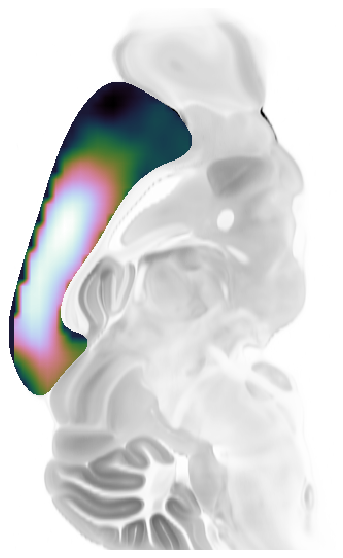

In [23]:
fig = plt.figure(figsize=(10,10))
plt.imshow(allen.get_data()[:,:,200],  cmap='Greys', aspect='equal');
plt.imshow(gradient_allen[:,:,200],  cmap="cubehelix_r", aspect='equal');
plt.axis('off');

### Transform our 200um template space to Allen space

In [14]:
template_200 = nb.load('/home/julia/data/gradients/atlas/200um/ABI_template_200um.nii')

In [15]:
template_200 = jo2allen_vol(template_200.get_data())

In [10]:
x = np.load('/home/julia/data/gradients/atlas/epfl_cell_atlas/x2vol.npy')
y = np.load('/home/julia/data/gradients/atlas/epfl_cell_atlas/y2vol.npy')
z = np.load('/home/julia/data/gradients/atlas/epfl_cell_atlas/z2vol.npy')

In [11]:
def scale_cells(x,y,z,factor=8):
    return x/factor, y/factor, z/factor

In [12]:
x, y, z = scale_cells(x,y,z)

In [6]:
mask_200 = nb.load('/home/julia/data/gradients/atlas/cortex/cortex_mask_200um.nii.gz').get_data()
mask_200 = jo2allen_vol(mask_200)

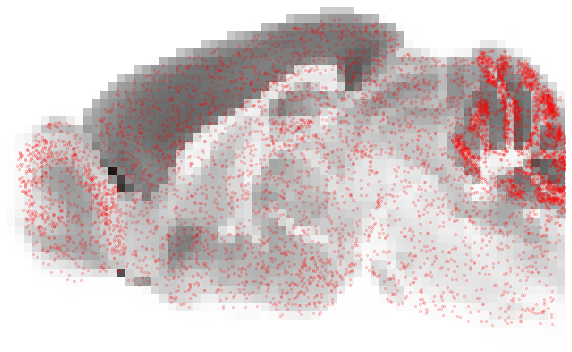

In [17]:
sns.set_context('poster')
fig = plt.figure(figsize=(10,15))
z_slice = 31
z_idx = np.where(np.abs(z-z_slice)<.001)
plt.imshow((template_200[:,:,z_slice].T),  cmap='Greys', aspect='equal');
plt.scatter(x[z_idx], y[z_idx], marker='.', color='red', s=1, alpha=0.5);
plt.imshow((mask_200[:,:,31].T),  cmap='Greys', aspect='equal', alpha=0.2);
plt.axis('off');

In [27]:
np.save('/home/julia/data/gradients/atlas/epfl_cell_atlas/x2vol_200.npy', x)
np.save('/home/julia/data/gradients/atlas/epfl_cell_atlas/y2vol_200.npy', y)
np.save('/home/julia/data/gradients/atlas/epfl_cell_atlas/z2vol_200.npy', z)

In [18]:
nb.save(nb.Nifti1Image(template_200, allen.affine, allen.header),
               '/home/julia/data/gradients/atlas/allen_api/template_200.nii.gz')
nb.save(nb.Nifti1Image(mask_200, allen.affine, allen.header),
               '/home/julia/data/gradients/atlas/cortex/cortex_mask_200um_allen.nii.gz')

In [7]:
for g in range(6):
    gradient = nb.load('/home/julia/data/gradients/results/gradient000%s.nii.gz' %str(g)).get_data()
    gradient_allen = jo2allen_vol(gradient)
    nb.save(nb.Nifti1Image(gradient_allen, allen.affine, allen.header),
            '/home/julia/data/gradients/results/gradient000%s_lowres_allen.nii.gz' %str(g))